In [6]:
!pip install ipython matplotlib
!pip install mesa


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.7/425.7 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 12

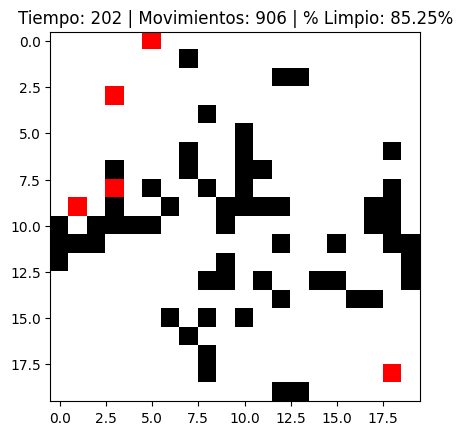

In [12]:
# Importar las bibliotecas necesarias
import mesa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Definición de las clases para el modelo y los agentes
class CleanAgent(mesa.Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.moves = 0

    def clean_cell(self):
        if self.pos in self.model.dirty_cells:
            self.model.dirty_cells.remove(self.pos)

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        empty_steps = [step for step in possible_steps if self.model.is_cell_available(step)]
        if empty_steps:
            new_position = self.random.choice(empty_steps)
            self.model.grid.move_agent(self, new_position)
            self.moves += 1
            self.model.total_moves += 1

    def step(self):
        if self.pos in self.model.dirty_cells:
            self.clean_cell()
        else:
            self.move()

class CleanModel(mesa.Model):
    def __init__(self, NumberAgents=5, widthM=20, heightN=20, dirtycellPercent=0.4, maxTimeExecution=200):
        super().__init__()
        self.num_agents = NumberAgents
        self.grid = mesa.space.MultiGrid(widthM, heightN, torus=True)
        self.schedule = mesa.time.RandomActivation(self)
        self.maxTimeExecution = maxTimeExecution
        self.time = 0
        self.total_moves = 0
        self.dirty_cells = set()
        self.percentage_clean = 0.0  # Inicializar el porcentaje limpio

        for x in range(widthM):
            for y in range(heightN):
                if self.random.random() < dirtycellPercent:
                    self.dirty_cells.add((x, y))

        for i in range(self.num_agents):
            agent = CleanAgent(i, self)
            self.schedule.add(agent)
            self.grid.place_agent(agent, (1, 1))

    def is_cell_available(self, pos):
        agents = self.grid.get_cell_list_contents([pos])
        return len(agents) == 0 or pos == (1, 1)

    def step(self):
        self.schedule.step()
        self.time += 1

        # Calcular el porcentaje de celdas limpias
        total_cells = self.grid.width * self.grid.height
        clean_cells = total_cells - len(self.dirty_cells)
        self.percentage_clean = (clean_cells / total_cells) * 100

        # Verificar si todas las celdas están limpias o si se alcanzó el tiempo máximo
        if not self.dirty_cells or self.time >= self.maxTimeExecution:
            self.running = False

# Configuración del modelo y visualización
model = CleanModel(NumberAgents=5, widthM=20, heightN=20, dirtycellPercent=0.4, maxTimeExecution=200)
fig, ax = plt.subplots()
cmap = mcolors.ListedColormap(['white', 'black', 'red'])  # Blanco para limpias, negro para sucias, rojo para agentes
bounds = [0, 1, 2, 3]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Función de actualización para la animación
def update(frame):
    ax.clear()
    grid_data = np.zeros((model.grid.width, model.grid.height))

    # Celdas sucias
    for (x, y) in model.dirty_cells:
        grid_data[x][y] = 1

    # Agentes
    for agent in model.schedule.agents:
        x, y = agent.pos
        grid_data[x][y] = 2

    ax.imshow(grid_data, cmap=cmap, norm=norm)
    model.step()
    ax.set_title(f'Tiempo: {model.time} | Movimientos: {model.total_moves} | % Limpio: {model.percentage_clean:.2f}%')

ani = FuncAnimation(fig, update, frames=range(model.maxTimeExecution), repeat=False)

# Mostrar la animación en Google Colab
HTML(ani.to_jshtml())
